# Import data

In [1]:
%matplotlib inline

import glob
import os
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers
from keras.models import Model
from keras import applications
from keras.utils.np_utils import to_categorical 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Using TensorFlow backend.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Dimensions of our images.
img_width, img_height = 240, 240

# epochs and batch_size
epochs = 100
batch_size = 32

# path to train and validation data
train_data_dir = '/dev/shm/train_sample'
valid_data_dir = '/dev/shm/valid_sample'
# train_data_dir = '/dev/shm/train'
# valid_data_dir = '/dev/shm/valid'

In [4]:
# train_datagen = ImageDataGenerator(
#         rescale=1. / 255,      # Normalize pixel values to [0,1]
#         shear_range=0.2,       # Randomly applies shearing transformation
#         zoom_range=0.2,        # Randomly applies shearing transformation
#         horizontal_flip=True)  # Randomly flip the images

train_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

# train_generator = train_datagen.flow_from_directory(
#         train_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode=None,
#         shuffle=False)

Found 4911 images belonging to 46 classes.


In [6]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [7]:
valid_generator = datagen.flow_from_directory(
        valid_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size)

# valid_generator = datagen.flow_from_directory(
#         valid_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode=None,
#         shuffle=False)

Found 1690 images belonging to 46 classes.


In [11]:
n_classes = 46
train_samples = 4911
valid_samples = 1690

# Loading VGG 16 models

In [12]:
model_vgg = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, 3))

In [13]:
bottleneck_features_train = model_vgg.predict_generator(train_generator, np.ceil(train_samples/float(batch_size)))
np.save(open('/dev/shm/models/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [14]:
bottleneck_features_validation = model_vgg.predict_generator(valid_generator, np.ceil(valid_samples/float(batch_size)))
np.save(open('/dev/shm/models/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [15]:
num_classes = len(train_generator.class_indices)

train_data = bottleneck_features_train
train_labels = to_categorical(train_generator.classes[:train_samples], num_classes=num_classes)

validation_data = bottleneck_features_validation
validation_labels = to_categorical(valid_generator.classes[:valid_samples], num_classes=num_classes)

In [16]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_data.shape[1:]))
model_top.add(Dense(512, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(n_classes, activation='softmax'))

model_top.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

In [17]:
model_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                23598     
Total params: 12,869,166
Trainable params: 12,869,166
Non-trainable params: 0
_________________________________________________________________


# Pre-Training and Evaluation

In [18]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/bottleneck_features.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model_top.fit(
        train_data,
        train_labels,
        verbose=2,
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[checkpointer, early_stopping],
        validation_data=(validation_data, validation_labels))

Train on 4911 samples, validate on 1690 samples
Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.13550, saving model to models/bottleneck_features.h5
3s - loss: 8.1163 - acc: 0.0973 - val_loss: 3.1424 - val_acc: 0.1355
Epoch 2/100
Epoch 00001: val_acc improved from 0.13550 to 0.13964, saving model to models/bottleneck_features.h5
3s - loss: 3.3508 - acc: 0.1240 - val_loss: 3.2169 - val_acc: 0.1396
Epoch 3/100
Epoch 00002: val_acc did not improve
2s - loss: 3.2219 - acc: 0.1399 - val_loss: 3.1916 - val_acc: 0.1349
Epoch 4/100
Epoch 00003: val_acc did not improve
2s - loss: 3.1947 - acc: 0.1324 - val_loss: 3.1482 - val_acc: 0.1367
Epoch 5/100
Epoch 00004: val_acc did not improve
2s - loss: 3.1462 - acc: 0.1372 - val_loss: 3.1548 - val_acc: 0.1148
Epoch 6/100
Epoch 00005: val_acc did not improve
2s - loss: 3.1179 - acc: 0.1328 - val_loss: 3.3270 - val_acc: 0.1385
Epoch 7/100
Epoch 00006: val_acc did not improve
2s - loss: 3.1018 - acc: 0.1311 - val_loss: 3.1924 - val_acc: 0.1225
E

In [19]:
model_top.evaluate(validation_data, validation_labels)

1472/1690 [=========================>....] - ETA: 0s

[3.702462995969332, 0.12721893491124261]

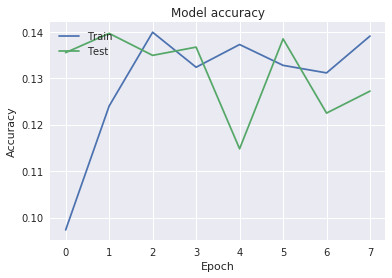

In [20]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Fine Tuning

In [21]:
# top_model = Sequential()
# top_model.add(Flatten(input_shape=model_vgg.output_shape[1:]))
# top_model.add(Dense(512, activation='relu'))
# top_model.add(Dropout(0.5))
# top_model.add(Dense(n_classes, activation='softmax'))

# top_model.load_weights('models/bottleneck_features.h5')

model = Model(inputs=model_vgg.input, outputs=model_top(model_vgg.output))

In [22]:
for layer in model.layers[:15]:
    layer.trainable = False

In [23]:
# Compile the model with a SGD/momentum optimizer and a slow learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0         
__________

# Training

In [ ]:
# Model saving callback
checkpointer = ModelCheckpoint(filepath='models/finetuning_full.h5', monitor='val_acc', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=5)

history = model.fit_generator(
        train_generator,
        steps_per_epoch=np.ceil(train_samples/float(batch_size)),
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        verbose=2,
        validation_data=valid_generator,
        validation_steps=np.ceil(valid_samples/float(batch_size)))

Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.25148, saving model to models/finetuning_full.h5
142s - loss: 3.0778 - acc: 0.1569 - val_loss: 2.7913 - val_acc: 0.2515
Epoch 2/100
Epoch 00001: val_acc improved from 0.25148 to 0.40296, saving model to models/finetuning_full.h5
141s - loss: 2.6760 - acc: 0.2613 - val_loss: 2.4104 - val_acc: 0.4030
Epoch 3/100
Epoch 00002: val_acc improved from 0.40296 to 0.45976, saving model to models/finetuning_full.h5
141s - loss: 2.4334 - acc: 0.3404 - val_loss: 2.2193 - val_acc: 0.4598
Epoch 4/100
Epoch 00003: val_acc improved from 0.45976 to 0.53964, saving model to models/finetuning_full.h5
141s - loss: 2.2456 - acc: 0.4011 - val_loss: 1.9639 - val_acc: 0.5396
Epoch 5/100
Epoch 00004: val_acc improved from 0.53964 to 0.56805, saving model to models/finetuning_full.h5
141s - loss: 2.1113 - acc: 0.4369 - val_loss: 1.8207 - val_acc: 0.5680
Epoch 6/100
Epoch 00005: val_acc improved from 0.56805 to 0.58284, saving model to models/finetuning_fu

# Evaluation

In [ ]:
model.evaluate_generator(valid_generator, valid_samples)

In [ ]:
fig, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()